In [1]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [96]:
from abc import ABC, abstractmethod
import numpy as np
import time

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)
    
class Loss(ABC):
    @abstractmethod
    def forward(self, pred, target):
        pass

    @abstractmethod
    def backward(self, pred, target):
        pass

    def __call__(self, pred, target):
        return self.forward(pred, target)

class Layer(ABC):
    def __init__(self, activation='sigmoid'):
        self.activation = activation
        
    @abstractmethod
    def forward(self, inputs):
        pass
    @abstractmethod
    def backward(self, outputs):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size, activation='sigmoid'):
        super().__init__(activation=activation)
        # self.weights = np.random.rand(input_size, output_size)
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)

        self.bias = np.random.rand(output_size)
        self.shape = self.weights.shape

    def forward(self, inputs):
        self.inputs = inputs
        self.z = inputs @ self.weights + self.bias

        if self.activation == 'sigmoid':
            self.output = sigmoid(self.z)
        elif self.activation == 'relu':
            self.output = relu(self.z)
        else:
            self.output = self.z

        return self.output

    def backward(self, d_next, lr=0.01):
        if self.activation == 'sigmoid':
            d = sigmoid_derivative(self.z) * d_next
        elif self.activation == 'relu':
            d = relu_derivative(self.z) * d_next
        else:
            d = d_next

        dl_dw = self.inputs.T @ d
        dl_db = np.sum(d, axis=0)
        dl_dx = d @ self.weights.T

        self.weights -= dl_dw * lr
        self.bias -= dl_db * lr

        return dl_dx, dl_dw, dl_db

class Flatten(Layer):
    def __init__(self):
        super().__init__(activation=None)

    def forward(self, inpt):
        if len(inpt.shape) == 3:
            batch_size = inpt.shape[0]

        return np.reshape(inpt, (batch_size, inpt.shape[1] * inpt.shape[2]))

    def backward(self, d_next):
        return d_next, 0, 0

class Normalize(Layer):
    def __init__(self):
        super().__init__(activation=None)

    def forward(self, inpt):
        self.scale = np.max(inpt)
        return inpt / self.scale

    def backward(self, d_next):
        return d_next / self.scale, 0, 0

class MSE(Loss):
    def forward(self, pred, target):
        return np.square(np.subtract(pred, target)).mean(axis=1)

    def backward(self, pred, target):
        return 2 * (pred - target) / pred.shape[0]

class Model(ABC):
    def __init__(self, loss_fn=None):
        self.loss_fn = loss_fn
        self.layers = []

    def add(self, layer):
        if type(layer) == Layer: 
            self.layers.append(layer)
        elif type(layer) == list:
            self.layers.extend(layer)
        else:
            raise Exception("Invalid layer")

    def __call__(self, inpt):
        return self.forward(inpt)

    def forward(self, inpt):
        output = inpt
        for layer in self.layers:
            output = layer.forward(output)

        return output

    @abstractmethod
    def backward(self, inpt):
        pass
            

class ClassifierModel(Model):
    def __init__(self, loss_fn=MSE()):
        super().__init__(loss_fn=loss_fn)
        self.accs = None
        self.losses = None

    def backward(self, one_hot_target, target_argmax):
        pred = self.layers[-1].output
        loss = self.loss_fn(pred, one_hot_target)

        d_loss = self.loss_fn.backward(pred, one_hot_target)

        dl_dx = d_loss
        for layer in self.layers[::-1]:
            dl_dx, _, _ = layer.backward(dl_dx)

        if self.losses is not None:
            self.losses.append(np.mean(loss))

        pred_argmax = np.argmax(pred, axis=1)
        # target_argmax = np.argmax(target, axis=1)
        acc = np.sum(pred_argmax == target_argmax) / len(pred_argmax)
        
        if self.accs is not None:
            self.accs.append(acc)

        return loss, acc

    def train(self, data_x, data_y, epochs=100, batch_size=32, print_freq=10):
        start_time = time.time()
        one_hot_target = np.eye(10)[data_y]
        num_samples = data_x.shape[0]
        
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_acc = []
            num_batches = num_samples // batch_size
            for batch_start in range(0, num_samples, batch_size):
                
                batch_end = min(batch_start + batch_size, num_samples)
                batch_x = data_x[batch_start:batch_end]
                batch_y = one_hot_target[batch_start:batch_end]

                output= self.forward(batch_x)

                loss, acc = self.backward(batch_y, data_y[batch_start:batch_end])
                epoch_loss += loss.sum()
                epoch_acc += [acc]            
            # Average loss for the epoch
            epoch_loss /= num_samples
            epoch_acc = np.mean(epoch_acc)

            # Print progress
            if (epoch + 1) % print_freq == 0:
                avg_epoch_time = (time.time() - start_time) / (epoch + 1)
                print(f"Epoch {epoch + 1}/{epochs}: Loss - {epoch_loss:.4f}. Acc - {epoch_acc:.4f}. Avg epoch time: {avg_epoch_time:.4f}s")

        total_time = time.time() - start_time
        print(f"Finished training for {epochs} epochs: Final Loss - {epoch_loss:.4f}. Acc - {epoch_acc:.4f}. Total time: {total_time:.4f}s")


    def test(self, data_x, data_y):
        pred = self(data_x)
        pred_argmax = np.argmax(pred, axis=1)

        target_argmax = np.argmax(data_y, axis=1)

        print(pred_argmax.shape, target_argmax.shape)

        return np.sum(target_argmax == pred_argmax) / len(pred_argmax)

    def get_stats(self, data_x, data_y):
        best_acc_train = np.max(self.accs)
        acc_test = self.test(data_x, data_y)

        return {'acc_train': best_acc_train, 'acc_test': acc_test}

    def get_wrong_predictions(self, data_x, data_y):
        pred = self(data_x)
        
    def start_loss_history(self):
        self.losses = []

    def start_acc_history(self):
        self.accs = []

    def get_loss_history(self):
        return self.losses

    def get_acc_history(self):
        return self.accs

In [97]:
import time
import matplotlib.pyplot as plt

model = ClassifierModel()

activation = 'sigmoid'

dense1 = Dense(28 * 28, 256, activation='relu')
dense2 = Dense(256, 64, activation='relu')
dense3 = Dense(64, 10, activation='sigmoid')
flatten = Flatten()
normalize = Normalize()

model.add([flatten, normalize, dense1, dense2, dense3])
model.start_loss_history()
model.start_acc_history()

n_samples = 60000

data_x = train_images[:n_samples]
data_y = train_labels[:n_samples]

model.train(data_x, data_y, batch_size = 256, epochs=100, print_freq=10)

Epoch 10/100: Loss - 0.0216. Acc - 0.8894. Avg epoch time: 1.2930s
Epoch 20/100: Loss - 0.0172. Acc - 0.9084. Avg epoch time: 1.3190s
Epoch 30/100: Loss - 0.0151. Acc - 0.9184. Avg epoch time: 1.3343s
Epoch 40/100: Loss - 0.0136. Acc - 0.9256. Avg epoch time: 1.3656s
Epoch 50/100: Loss - 0.0125. Acc - 0.9312. Avg epoch time: 1.3796s
Epoch 60/100: Loss - 0.0117. Acc - 0.9361. Avg epoch time: 1.3932s
Epoch 70/100: Loss - 0.0109. Acc - 0.9403. Avg epoch time: 1.3755s
Epoch 80/100: Loss - 0.0103. Acc - 0.9442. Avg epoch time: 1.3637s
Epoch 90/100: Loss - 0.0098. Acc - 0.9472. Avg epoch time: 1.3551s
Epoch 100/100: Loss - 0.0093. Acc - 0.9499. Avg epoch time: 1.3537s
Finished training for 100 epochs: Final Loss - 0.0093. Acc - 0.9499. Total time: 135.3682s


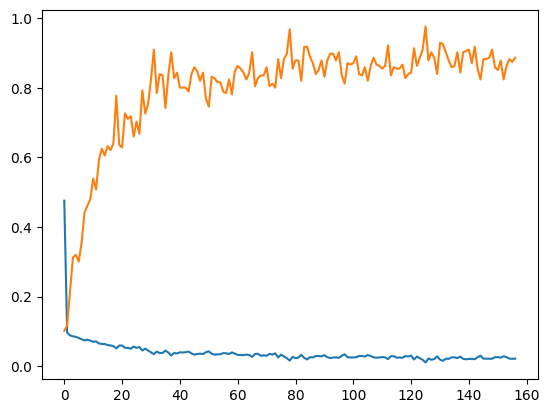

In [83]:
batches_per_dataset = 1000 // 64

plt.plot(model.get_loss_history()[::batches_per_dataset])
plt.plot(model.get_acc_history()[::batches_per_dataset])

In [88]:
stats = model.get_stats(test_images, np.eye(10)[test_labels])

(10000,) (10000,)


In [89]:
train_acc = stats['acc_train']
test_acc = stats['acc_test']

print(train_acc, test_acc)

0.99609375 0.948


In [77]:
stats

{'acc_train': 1.0, 'acc_test': 0.6715}

In [74]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [32]:
model.get_acc_history()

In [21]:
model.get_loss_history()

[]

In [ ]:
model.get_loss_histo

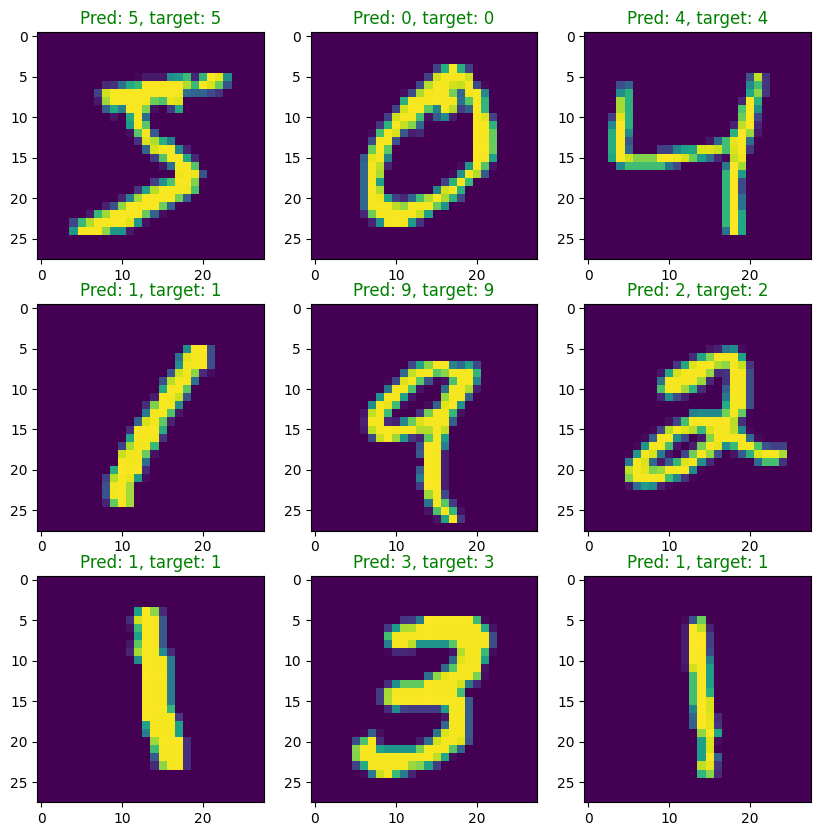

In [90]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axs = axs.flatten()

test_x = train_images[:len(axs)]
test_y = train_labels[:len(axs)]

pred = model.forward(test_x)
pred_argmax = np.argmax(pred, axis=1)

for ax, image, pred, target in zip(axs, test_x, pred_argmax, test_y):
    color = 'green' if pred == target else 'red'
    ax.set_title("Pred: {}, target: {}".format(pred, target), color=color)
    ax.imshow(image)

In [116]:
train_images.shape

(60000, 28, 28)

In [117]:
test_images.shape

(10000, 28, 28)